In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
dl = LFWDataLoader()

train_ds, train_dl = dl.train_dataset, dl.train_dataloader
val_ds, val_dl = dl.val_dataset, dl.val_dataloader
test_ds, test_dl = dl.test_dataset, dl.test_dataloader

(10586, 3, 125, 94)
(1323, 3, 125, 94)
(1324, 3, 125, 94)


In [11]:
from model import Encoder, Decoder, AutoEncoder

model = AutoEncoder()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, optim, device, train_dl, val_dl)
torch.cuda.empty_cache()
trainer.train_model(epochs=10)

54799510
Iteration 0, loss = 0.2637
Avg Loss on Val: 0.2541998669617158

Iteration 100, loss = 0.0318
Avg Loss on Val: 0.0319617063479316

Iteration 200, loss = 0.0185
Avg Loss on Val: 0.023079891850177506

Iteration 300, loss = 0.0215
Avg Loss on Val: 0.01811150859173079

Iteration 400, loss = 0.0180
Avg Loss on Val: 0.016918354464652844

Iteration 500, loss = 0.0181
Avg Loss on Val: 0.016719538466374678

Iteration 600, loss = 0.0193
Avg Loss on Val: 0.01645550333467641

Iteration 700, loss = 0.0165
Avg Loss on Val: 0.01538488739415219

Iteration 800, loss = 0.0142
Avg Loss on Val: 0.015400196376599763

Iteration 900, loss = 0.0118
Avg Loss on Val: 0.014662392157361023

Iteration 1000, loss = 0.0139
Avg Loss on Val: 0.014814380416296478

Iteration 0, loss = 0.0171
Avg Loss on Val: 0.014669470320966906

Iteration 100, loss = 0.0140
Avg Loss on Val: 0.013941240489931036

Iteration 200, loss = 0.0110
Avg Loss on Val: 0.013463521362247323

Iteration 300, loss = 0.0163
Avg Loss on Val: 0.0

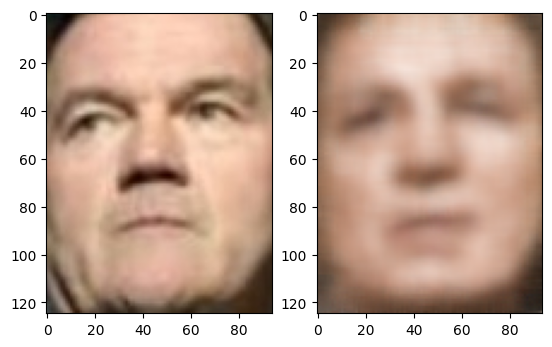

In [12]:
f = plt.figure()
tensor_image, = test_ds[0]
f.add_subplot(1,2,1)
plt.imshow(tensor_image.permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image.unsqueeze(0)
    scores = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

In [ ]:
import gc 
model = 1
del model
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()